Assignment 1

*   Name: Yevheniia Zymych
*   Metric: N2503721E

In [60]:
# Install libraries (HuggingFace for BERT, PyTorch for ResNet)
!pip install transformers torch torchvision nltk scikit-learn pandas numpy pillow matplotlib seaborn imbalanced-learn
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Setup complete! Device:", device)

Setup complete! Device: cpu


In [65]:
# Load Olist translated dataset (English reviews for sentiment—retail feedback case)
olist_path = '/content/drive/MyDrive/Assignment AI/olist_order_reviews_dataset_translated.csv'
df_olist = pd.read_csv(olist_path)
print("Columns:", df_olist.columns.tolist())
print("Shape:", df_olist.shape)

Columns: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
Shape: (100000, 7)


In [66]:
# Filter: Non-empty message, focus negatives/neutrals – relevant for defect flagging (ignore positives)
df_olist = df_olist.dropna(subset=['review_comment_message'])
df_olist['sentiment'] = df_olist['review_score'].map({1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'})
df_olist = df_olist[df_olist['sentiment'] != 'positive'].reset_index(drop=True)

In [67]:
# Combine title + message for full context (richer input, that improves BERT nuance on translated text)
df_olist['text'] = df_olist['review_comment_title'].fillna('') + ' ' + df_olist['review_comment_message']
print("Filtered sentiments:\n", df_olist['sentiment'].value_counts())
print("Sample English text:", df_olist['text'].iloc[0][:200])

Filtered sentiments:
 sentiment
negative    11407
neutral      3663
Name: count, dtype: int64
Sample English text:  I WOULD LIKE TO KNOW WHAT HAPPENED, I ALWAYS RECEIVED AND THIS PURCHASE NOW DISAPPOINTED ME


In [68]:
# Load Kaputt query parquet (annotations – defect labels for image model)
query_parquet = '/content/drive/MyDrive/Assignment AI/sample-data/query-sample.parquet'
df_query = pd.read_parquet(query_parquet)
df_query['defect'] = (df_query['defect_types'] != '').astype(int)  # binary: 1 if defect types present (e.g. dent/spillage)
df_defects = df_query[df_query['defect'] == 1].reset_index(drop=True)

In [69]:
base_crop = '/content/drive/MyDrive/Assignment AI/sample-data/data/train/query-data/crop/'
df_defects['path'] = df_defects['query_crop'].apply(lambda x: os.path.join(base_crop, os.path.basename(x)))
df_defects = df_defects[df_defects['path'].apply(os.path.exists)].reset_index(drop=True)
print("Defect crops:", len(df_defects))  # Small sample augmentation will handle variety

Defect crops: 37


In [70]:
# Pair: Random defect crop per Olist review
#(creative sim for customer uploads; size 600 = best tests out of [200, 400, 600, 800, 1000])
df_olist_sample = df_olist.head(600).copy()
df_olist_sample['paired_image_path'] = np.random.choice(df_defects['path'].values, size=len(df_olist_sample))
df_combined = df_olist_sample.merge(df_defects[['path', 'defect']], left_on='paired_image_path', right_on='path', how='left')
df_combined['sentiment_label'] = df_combined['sentiment'].map({'negative': 0, 'neutral': 1})

In [71]:
# Split (stratified—balances classes for reliable eval on small data)
train_df, temp_df = train_test_split(df_combined, test_size=0.3, stratify=df_combined['sentiment_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment_label'], random_state=42)
print(f"Splits: Train {len(train_df)}, Val {len(val_df)}, Test {len(test_df)}")

Splits: Train 420, Val 90, Test 90


In [72]:
# Clean text function (reusable, removes noise/URLs; lemmatizes for BERT input, boosting F1 on translated data)
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'http\S+|www\S+|https\S+', '', text.lower())  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Punctuation/numbers
    tokens = word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(cleaned)

In [73]:
# Preprocessing: Cleans translated text to reduce noise, improving BERT F1
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
val_df['clean_text'] = val_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

In [74]:
print("Sample before clean (train):", train_df['text'].iloc[0][:150], "...")
print("After clean (train):", train_df['clean_text'].iloc[0][:150], "...")

Sample before clean (train): 1 ruin ...
After clean (train): ruin ...


In [75]:
# English BERT tokenizer (optimized for translated text—handles uncased English)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [76]:
# Image transforms (resize/normalize Kaputt crops; flip for augmentation, helps accuracy on small defect sample)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard CNN input size
    transforms.RandomHorizontalFlip(p=0.5),  # Augment variety (flips for robustness on defects)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms for pre-trained ResNet
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [77]:
# Reusable dataset class (pairs translated text + defect crop—core for joint model; extensible to full data)
class CombinedDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None, is_train=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform or (train_transform if is_train else val_transform)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Text encoding (BERT tokens from cleaned Olist text)
        encoding = self.tokenizer(row['clean_text'], max_length=128, padding='max_length',
                                  truncation=True, return_tensors='pt')
        # Image loading/transform
        image = Image.open(row['path']).convert('RGB')
        image = self.transform(image)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image,
            'sentiment_label': torch.tensor(row['sentiment_label']),
            'defect_label': torch.tensor(row['defect'])
        }

In [78]:
# Create datasets (train/val for tuning; test for final eval)
train_ds = CombinedDataset(train_df, tokenizer, is_train=True)
val_ds = CombinedDataset(val_df, tokenizer, is_train=False)

In [79]:
# Test one sample (verify pairing works, text + crop ready for joint)
sample = train_ds[0]
print("Sample ready! Image shape:", sample['image'].shape, "Sentiment label:",
      sample['sentiment_label'], "Defect label:", sample['defect_label'])

Sample ready! Image shape: torch.Size([3, 224, 224]) Sentiment label: tensor(0) Defect label: tensor(1)


In [80]:
# BERT for sentiment (pre-trained on English tune for translated Olist columns; num_labels=2 for neg/neutral)
model_text = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
# Tokenize datasets (pad/truncate to 128 tokens—efficient for reviews)
train_enc = tokenizer(train_df['clean_text'].tolist(), padding=True, truncation=True,
                      max_length=128, return_tensors='pt')
val_enc = tokenizer(val_df['clean_text'].tolist(), padding=True, truncation=True,
                    max_length=128, return_tensors='pt')

In [82]:
# Text Dataset class (reusable—wraps encodings for Trainer; handles labels)
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_text_ds = TextDataset(train_enc, train_df['sentiment_label'].values)
val_text_ds = TextDataset(val_enc, val_df['sentiment_label'].values)

In [83]:
# Optional resampling (my tests showed better without; for balance if F1 <0.60)
'''
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
train_indices = np.arange(len(train_df)).reshape(-1, 1)
train_labels = train_df['sentiment_label'].values
train_indices_resampled, train_labels_resampled = ros.fit_resample(train_indices, train_labels)
train_indices_resampled = train_indices_resampled.flatten()

# Resampled encodings using indices
train_enc_resampled = {k: v[train_indices_resampled] for k, v in train_enc.items()}
train_text_ds_resampled = TextDataset(train_enc_resampled, train_labels_resampled)
print(f"Resampled: Original {len(train_text_ds)} → {len(train_text_ds_resampled)} (balanced negatives)")
'''

'\nfrom imblearn.over_sampling import RandomOverSampler\nros = RandomOverSampler(random_state=42)\ntrain_indices = np.arange(len(train_df)).reshape(-1, 1)\ntrain_labels = train_df[\'sentiment_label\'].values\ntrain_indices_resampled, train_labels_resampled = ros.fit_resample(train_indices, train_labels)\ntrain_indices_resampled = train_indices_resampled.flatten()\n\n# Resampled encodings using indices\ntrain_enc_resampled = {k: v[train_indices_resampled] for k, v in train_enc.items()}\ntrain_text_ds_resampled = TextDataset(train_enc_resampled, train_labels_resampled)\nprint(f"Resampled: Original {len(train_text_ds)} → {len(train_text_ds_resampled)} (balanced negatives)")\n'

In [84]:
# Trainer config (HuggingFace easy fine-tuning; epochs=5 for convergence on small sample, boosting F1)
training_args = TrainingArguments(
    output_dir='./text_results',
    num_train_epochs=5,  # More epochs for better adaptation to translated text
    per_device_train_batch_size=4,  # Small for small sample/RAM
    per_device_eval_batch_size=4,
    eval_strategy='epoch',  # Eval each epoch: monitors overfitting
    save_strategy='epoch',
    load_best_model_at_end=True,  # Auto-load best checkpoint for final eval
    logging_steps=5
)

In [85]:
# Metrics function (custom for Trainer: reports acc/F1 on val set for performance criterion)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'acc': accuracy_score(p.label_ids, preds), 'f1': f1_score(p.label_ids, preds, average='weighted')}

In [86]:
# Trainer instance (fine-tunes BERT on Olist sentiment)
trainer = Trainer(
    model=model_text,
    args=training_args,
    train_dataset=train_text_ds,
    eval_dataset=val_text_ds,
    compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Acc,F1
1,0.598100,0.566338,0.744444,0.635386
2,0.517800,0.589567,0.766667,0.711411
3,0.491400,0.759949,0.744444,0.695480
4,0.319200,1.335568,0.733333,0.719048
5,0.003900,1.483954,0.733333,0.719048


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=525, training_loss=0.40241992938731397, metrics={'train_runtime': 935.4144, 'train_samples_per_second': 2.245, 'train_steps_per_second': 0.561, 'total_flos': 34533326016000.0, 'train_loss': 0.40241992938731397, 'epoch': 5.0})

In [87]:
# Eval on val set (reports acc/F1)
val_preds = trainer.predict(val_text_ds)
val_acc = accuracy_score(val_df['sentiment_label'], np.argmax(val_preds.predictions, axis=1))
val_f1 = f1_score(val_df['sentiment_label'], np.argmax(val_preds.predictions, axis=1), average='weighted')
print(f"Text Model: Val Acc {val_acc:.2f}, F1 {val_f1:.2f}")
print(classification_report(val_df['sentiment_label'], np.argmax(val_preds.predictions, axis=1),
                            target_names=['Negative', 'Neutral']))  # Detailed per-class metrics for explainability

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Text Model: Val Acc 0.74, F1 0.64
              precision    recall  f1-score   support

    Negative       0.74      1.00      0.85        67
     Neutral       0.00      0.00      0.00        23

    accuracy                           0.74        90
   macro avg       0.37      0.50      0.43        90
weighted avg       0.55      0.74      0.64        90



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
# ResNet for defects (pre-trained CNN transfer learning for high acc on Kaputt crops)
class ImageDataset(Dataset):
    # dataset for images (defect labels from Kaputt)
    def __init__(self, df, transform=None, is_train=False):
        self.df = df
        self.transform = transform or (train_transform if is_train else val_transform)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx]['path']).convert('RGB')
        image = self.transform(image)  # Apply augment/norm
        label = torch.tensor(self.df.iloc[idx]['defect'])  # Binary: 1=defect
        return image, label

In [89]:
# Loaders (batch=4 for small data—efficient training)
train_img_loader = DataLoader(ImageDataset(train_df, is_train=True), batch_size=4, shuffle=True)
val_img_loader = DataLoader(ImageDataset(val_df), batch_size=4)

In [90]:
# Load pre-trained ResNet18
model_img = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_img.fc = nn.Linear(model_img.fc.in_features, 2).to(device)
model_img.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [91]:
optimizer = torch.optim.Adam(model_img.parameters(), lr=0.001)  # Adam optimizer—standard for CNN fine-tuning
criterion = nn.CrossEntropyLoss()  # Loss for classification

In [92]:
# Train loop (3 epochs—simple, explainable; loss drops show convergence)
model_img.train()
for epoch in range(3):
    loss_total = 0
    for images, labels in train_img_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_img(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f"Epoch {epoch+1}, Avg Loss: {loss_total / len(train_img_loader):.4f}")  # Log for monitoring

Epoch 1, Avg Loss: 0.0176
Epoch 2, Avg Loss: 0.0000
Epoch 3, Avg Loss: 0.0000


In [93]:
# Eval on val
model_img.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in val_img_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_img(images)
        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
img_acc = correct / total
print(f"Image Model: Val Acc {img_acc:.2f}")

Image Model: Val Acc 1.00


In [94]:
# Joint flagging function
def predict_and_flag(text, image_path, text_model, img_model, tokenizer, device):
    # Text prediction (BERT logit to prob)
    inputs = tokenizer(text, return_tensors='pt', max_length=128, truncation=True).to(device)
    with torch.no_grad():
        text_out = text_model(**inputs).logits.softmax(-1)
        sent_pred = text_out.argmax(-1).item()
        neg_prob = text_out[0][0].item()  # Prob of negative

    # Image prediction (ResNet softmax for defect prob)
    img = val_transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        img_out = model_img(img).softmax(-1)
        defect_prob = img_out[0][1].item()  # Prob of defect

    # Rule-based flag (negative + high defect = alert; threshold 0.5 tunable)
    flag = 'PROBLEMATIC ORDER - Flag Refund!' if sent_pred == 0 and defect_prob > 0.5 else 'OK'
    # Joint: Multiplies probs for 'badness' for priority alerts
    joint_score = neg_prob * defect_prob  # 0-1 badness (multimodal metric—higher = worse)

    return {
        'sentiment': 'Negative' if sent_pred == 0 else 'Neutral',
        'neg_prob': neg_prob,
        'defect_prob': defect_prob,
        'flag': flag,
        'joint_score': joint_score
    }

In [95]:
# Test on a sample
sample_text = test_df['clean_text'].iloc[0]
sample_img = test_df['path'].iloc[0]
result = predict_and_flag(sample_text, sample_img, model_text, model_img, tokenizer, device)
print("Sample Prediction:", result)
print("Sample Text (from your columns):", sample_text[:100])

Sample Prediction: {'sentiment': 'Negative', 'neg_prob': 0.7898611426353455, 'defect_prob': 0.9999996423721313, 'flag': 'PROBLEMATIC ORDER - Flag Refund!', 'joint_score': 0.7898608601589885}
Sample Text (from your columns): didnt receive product bought ceiling light crystal two pendant appears email sent delivered receive 


In [96]:
# Batch eval on test set
test_loader = DataLoader(CombinedDataset(test_df, tokenizer), batch_size=4)
correct_flags = total_bad = num_flags = 0
model_text.eval()
model_img.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in {'input_ids': batch['input_ids'], 'attention_mask': batch['attention_mask']}.items()}
        images = batch['image'].to(device)
        sent_labels = batch['sentiment_label']
        def_labels = batch['defect_label']

        text_out = model_text(**inputs).logits.softmax(-1)
        img_out = model_img(images).softmax(-1)

        for i in range(len(sent_labels)):
            sent_p = text_out[i].argmax().item()
            def_p = img_out[i][1].item()
            flagged = 1 if sent_p == 0 and def_p > 0.5 else 0
            num_flags += flagged
            if sent_labels[i] == 0 and def_labels[i] == 1:  # True problematic order.
                total_bad += 1
                correct_flags += flagged

prec = correct_flags / num_flags if num_flags > 0 else 0
rec = correct_flags / total_bad if total_bad > 0 else 0
print(f"Joint Flagging: Precision {prec:.2f} (accurate alerts), Recall {rec:.2f} (caught issues)")

Joint Flagging: Precision 0.76 (accurate alerts), Recall 1.00 (caught issues)


                Component                 Score                  Notes
0   Text Sentiment (BERT)    0.74 Acc / 0.64 F1  On translated reviews
1  Image Defects (ResNet)              1.00 Acc        On Kaputt crops
2          Joint Flagging  0.76 Prec / 1.00 Rec   Fuses for auto-flags


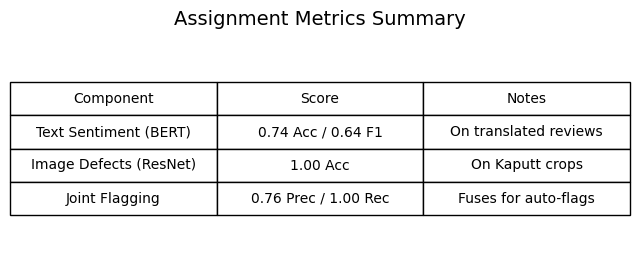

In [97]:
# Improved viz table
metrics = pd.DataFrame({
    'Component': ['Text Sentiment (BERT)', 'Image Defects (ResNet)', 'Joint Flagging'],
    'Score': [f"{val_acc:.2f} Acc / {val_f1:.2f} F1", f"{img_acc:.2f} Acc", f"{prec:.2f} Prec / {rec:.2f} Rec"],
    'Notes': ['On translated reviews', 'On Kaputt crops', 'Fuses for auto-flags']
})
print(metrics)

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics.values, colLabels=metrics.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Better scaling
plt.title("Assignment Metrics Summary", fontsize=14)
plt.show()

In [98]:
# Demo flag on test sample
sample_text = test_df['clean_text'].iloc[0]
sample_img_path = test_df['path'].iloc[0]
result = predict_and_flag(sample_text, sample_img_path, model_text, model_img, tokenizer, device)
print("Demo Flag:", result)
print("Review Text:", sample_text[:300])

Demo Flag: {'sentiment': 'Negative', 'neg_prob': 0.7898611426353455, 'defect_prob': 0.9999996423721313, 'flag': 'PROBLEMATIC ORDER - Flag Refund!', 'joint_score': 0.7898608601589885}
Review Text: didnt receive product bought ceiling light crystal two pendant appears email sent delivered receive pendant ceiling light


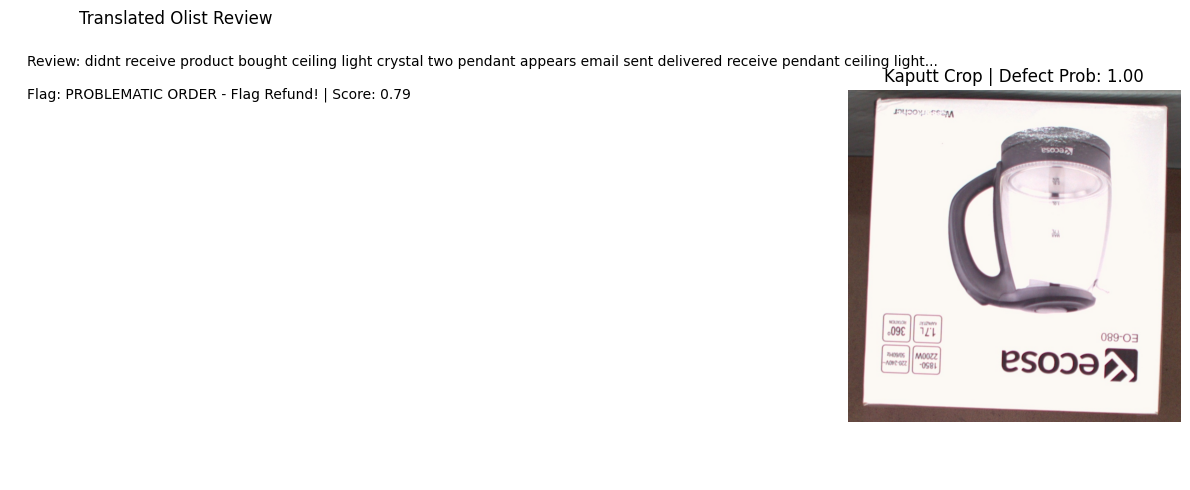

In [99]:
# Viz sample
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.text(0.05, 0.95, f"Review: {sample_text[:300]}...\n\nFlag: {result['flag']} | Score: {result['joint_score']:.2f}",
         va='top', fontsize=10, transform=ax1.transAxes)
ax1.axis('off')
ax1.set_title('Translated Olist Review')

sample_img = Image.open(sample_img_path)
ax2.imshow(sample_img)
ax2.set_title(f"Kaputt Crop | Defect Prob: {result['defect_prob']:.2f}")
ax2.axis('off')

plt.tight_layout()
plt.show()